In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge
import torch
import pandas as pd
from lexical_diversity import lex_div as ld

In [3]:
model_name = 'google/flan-t5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [4]:
def get_response_and_scores(prompt, reference):
    # Encode & Decode
    inputs = tokenizer.encode(prompt + tokenizer.eos_token, return_tensors="pt")
    attention_mask = torch.ones(inputs.shape, dtype=torch.long)  # Create attention mask
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50, num_return_sequences=1, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=False)

    input_ids = tokenizer.encode(response, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)  # Create attention mask for the response

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        
    loss = outputs.loss
    perplexity = torch.exp(loss)

    rouge = Rouge()
    scores = rouge.get_scores(response, reference)

    words = response.split()
    mtld_score = ld.mtld(words)

    response_length = len(response)

    df = pd.DataFrame({
        'Metric': ['ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Recall': [scores[0]['rouge-1']['r'], scores[0]['rouge-2']['r'], scores[0]['rouge-l']['r']],
        'Precision': [scores[0]['rouge-1']['p'], scores[0]['rouge-2']['p'], scores[0]['rouge-l']['p']],
        'F1 Score': [scores[0]['rouge-1']['f'], scores[0]['rouge-2']['f'], scores[0]['rouge-l']['f']],
    })

    print(f'ROUGE scores\n{df}')

    return response, perplexity.item(), scores, mtld_score, response_length


In [5]:
new_prompt = 'Describe the influence of transformer architecture in AI'
reference_text = 'Artificial Intelligence, with its ability to analyze massive data sets and learn from patterns, has revolutionized industries like healthcare, finance, and transportation, by driving efficiencies and enabling new services, while also raising ethical considerations around privacy and job displacement.'

response, perplexity, rouge_scores, mtld, response_length = get_response_and_scores(new_prompt, reference_text)
print('\nResponse:', response)
print('Perplexity:', perplexity)
print('MTLD:', mtld)
print('Response length:', response_length)

ROUGE scores
    Metric    Recall  Precision  F1 Score
0  ROUGE-1  0.027778   0.076923  0.040816
1  ROUGE-2  0.000000   0.000000  0.000000
2  ROUGE-L  0.027778   0.076923  0.040816

Response: <pad> AI has a profound impact on the way we think about the world</s>
Perplexity: 17.568204879760742
MTLD: 54.88000000000004
Response length: 70


In [6]:
model.config.output_attentions = True

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def visualize_attention(prompt, response):
    # Encode the prompt and response
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    # Get the attention weights from the model
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()  # Taking last layer's attention weights
    
    # Average attention weights across all heads
    attention_weights_avg = np.mean(attention_weights, axis=0)
    
    # Visualize averaged attention weights
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(attention_weights_avg, cmap='viridis')
    
    src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
    
    ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
    ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.colorbar(cax)
    plt.show()


/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/1010400705.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/1010400705.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


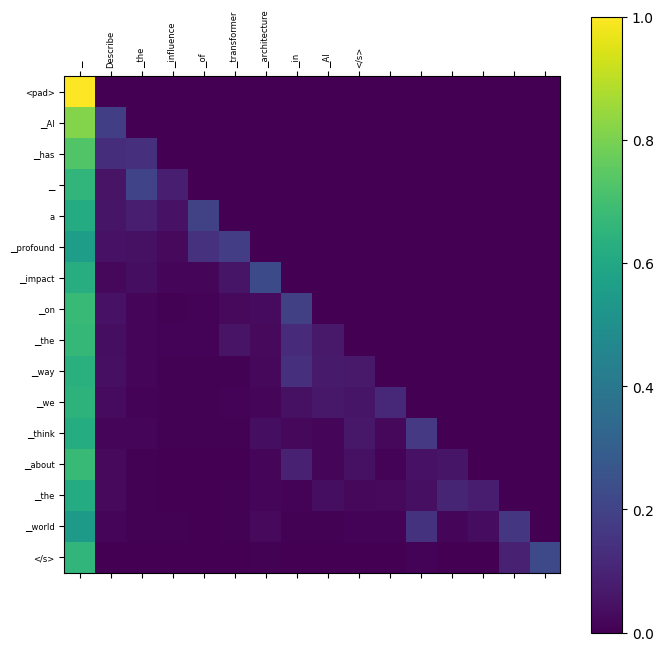

In [7]:
visualize_attention(new_prompt, response)

In [9]:
def visualize_attention_per_head(prompt, response):

    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    response_ids = tokenizer.encode(response, add_special_tokens=False, return_tensors="pt")
    
    outputs = model(input_ids, decoder_input_ids=response_ids, output_attentions=True)
    attention_weights = outputs.decoder_attentions[-1][0].squeeze().cpu().detach().numpy()
    
    num_heads = attention_weights.shape[0]
    
    for head in range(num_heads):
        fig, ax = plt.subplots(figsize=(8,8))
        cax = ax.matshow(attention_weights[head], cmap='viridis')
        
        src_tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
        tgt_tokens = tokenizer.convert_ids_to_tokens(response_ids.squeeze().tolist())
        
        ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
        ax.set_yticklabels([''] + tgt_tokens, fontsize=6)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.colorbar(cax)
        plt.title(f'Attention Head {head+1}')
        plt.show()

/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/601868510.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + src_tokens, rotation=90, fontsize=6)
/var/folders/3l/g5t448zx39gff0vm9hc1bps80000gn/T/ipykernel_58611/601868510.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + tgt_tokens, fontsize=6)


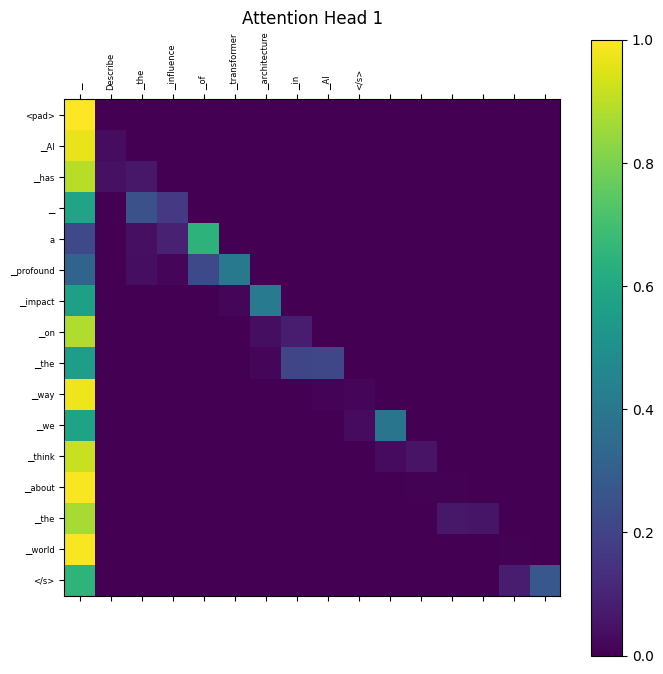

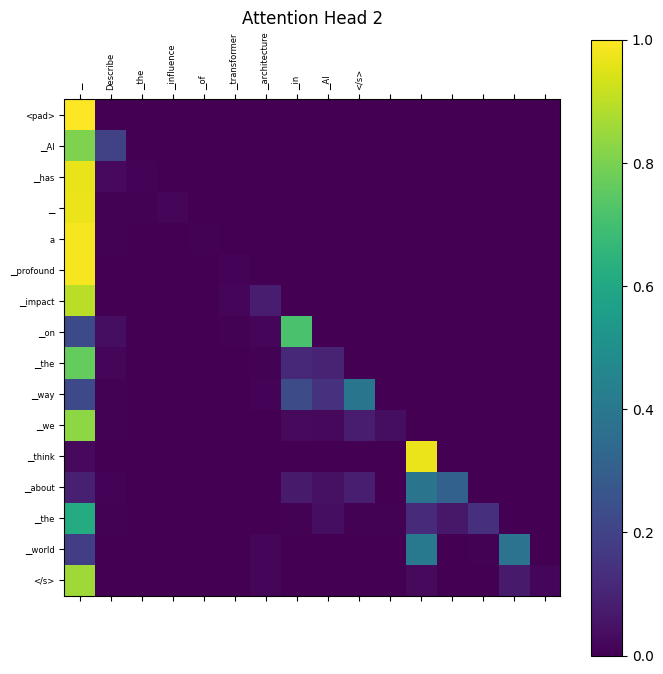

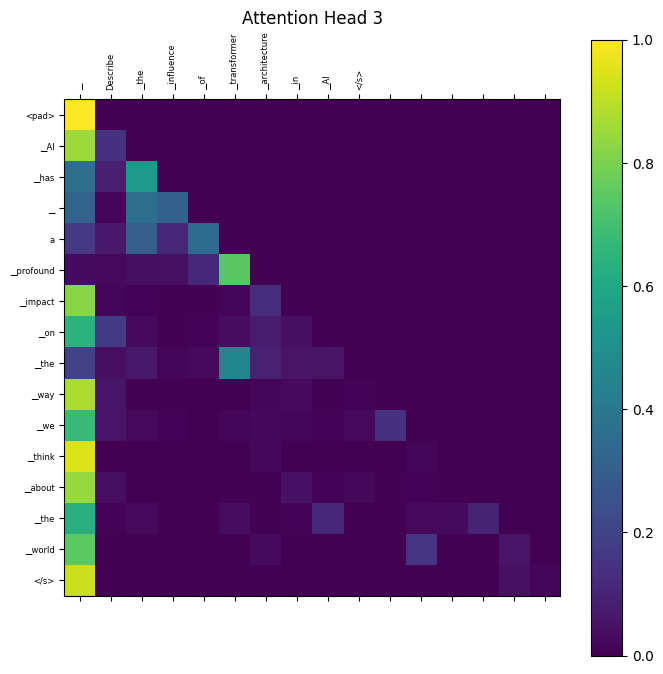

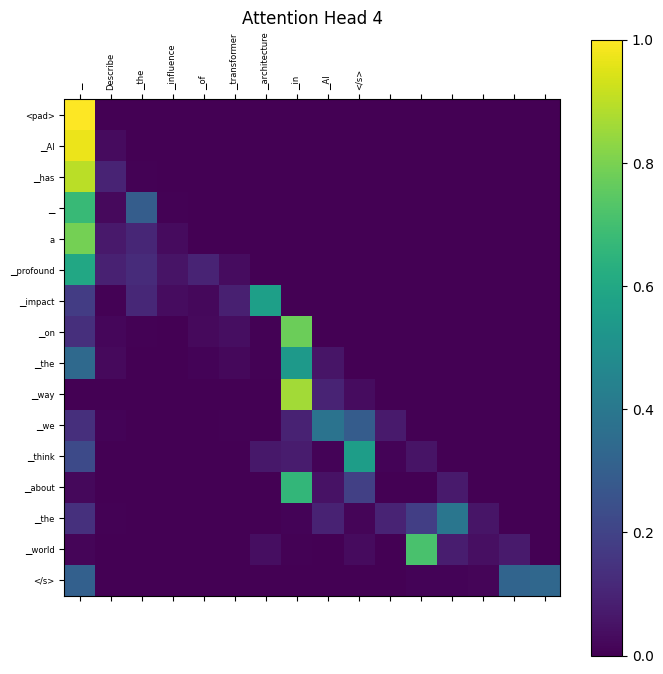

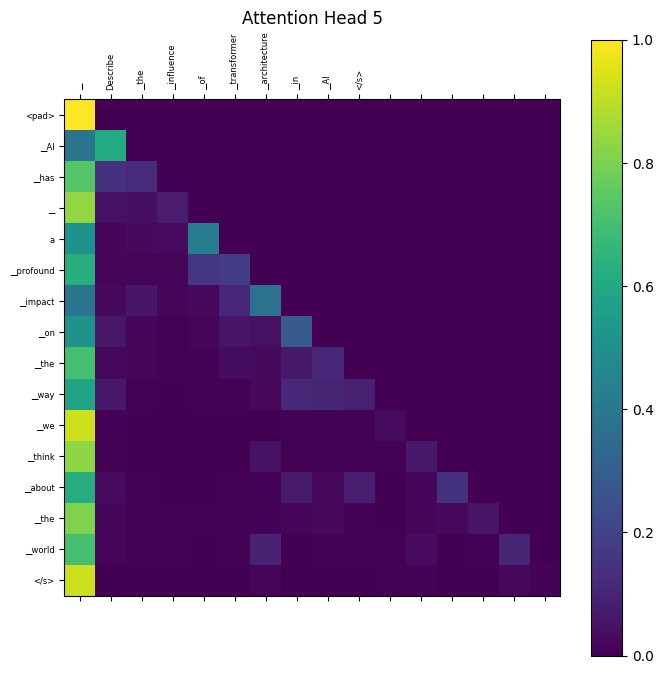

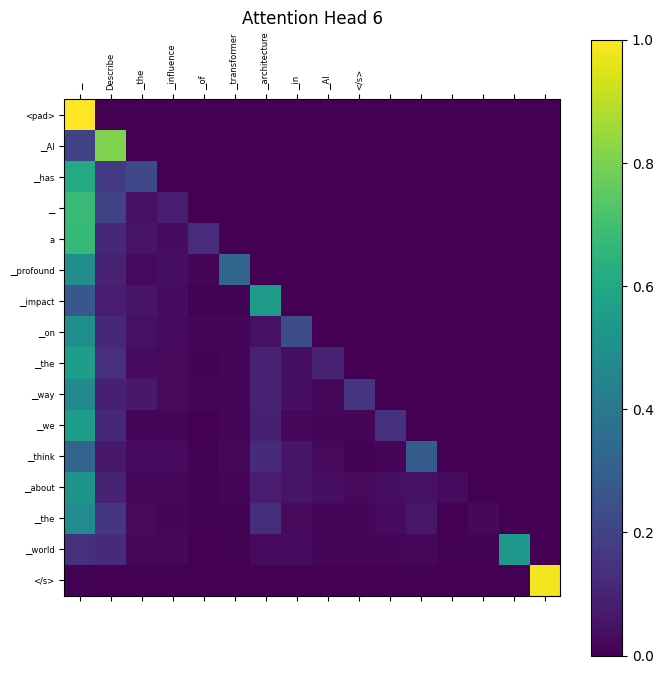

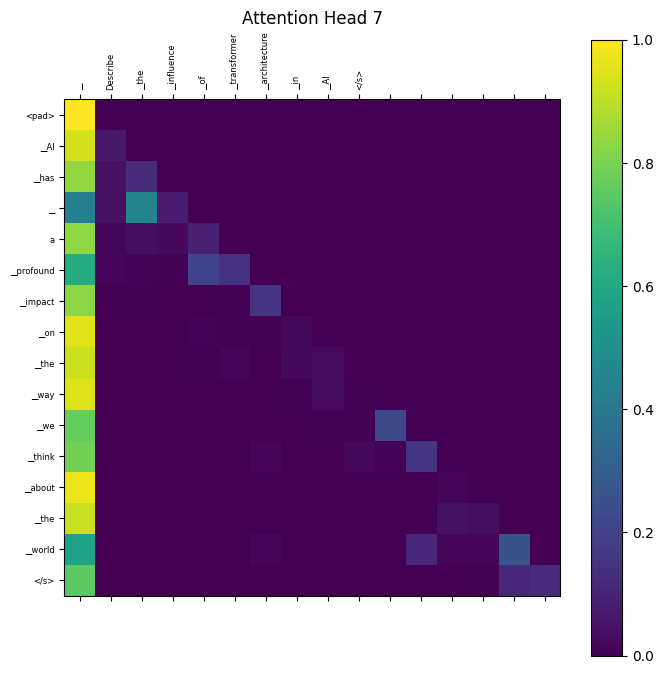

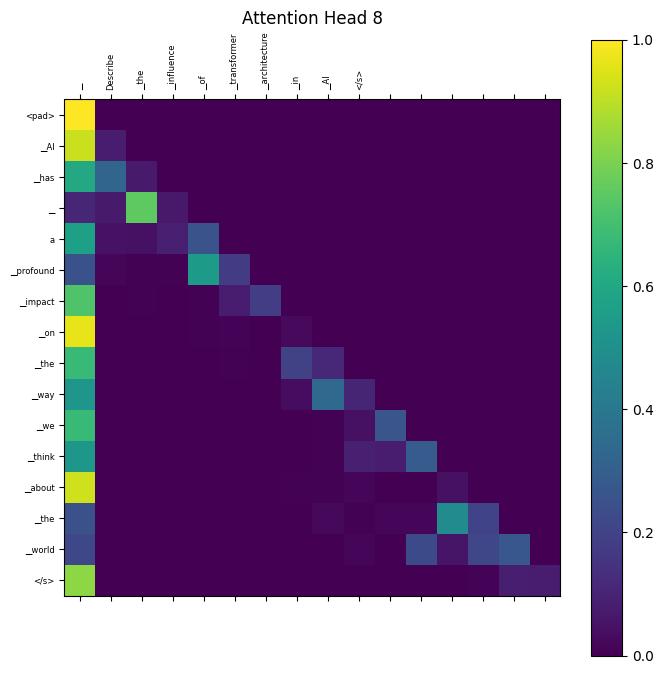

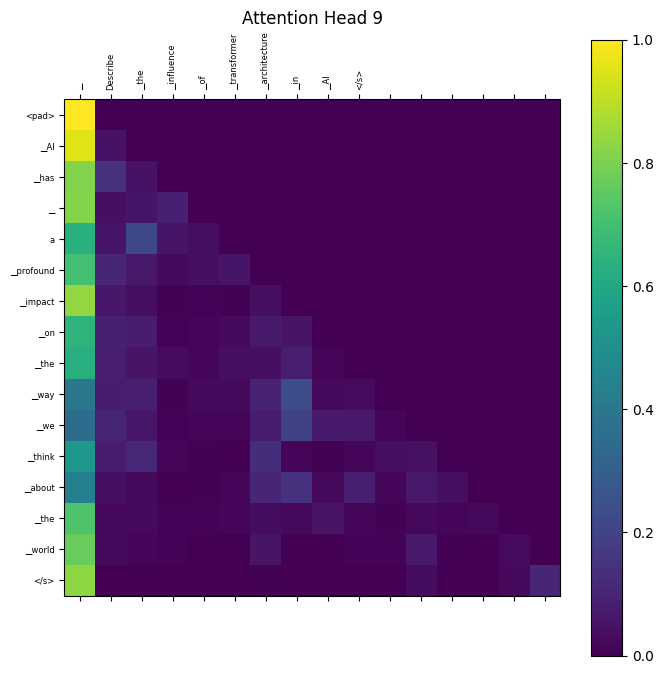

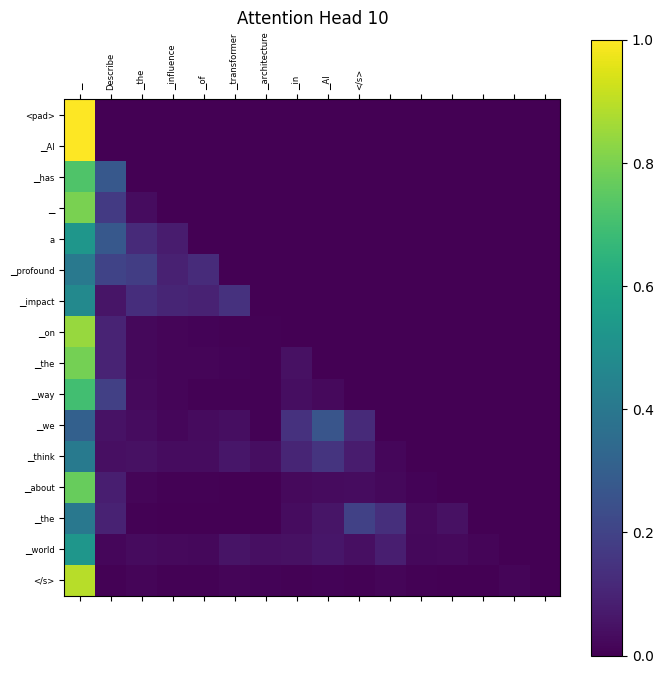

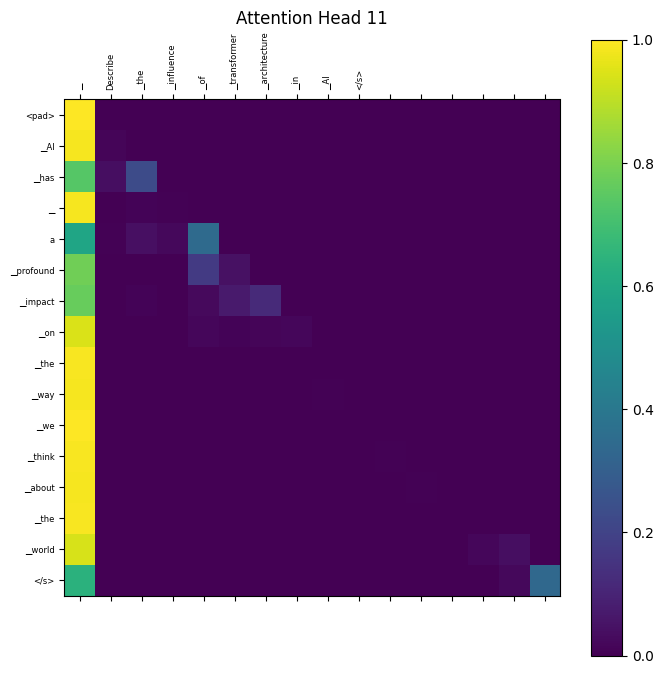

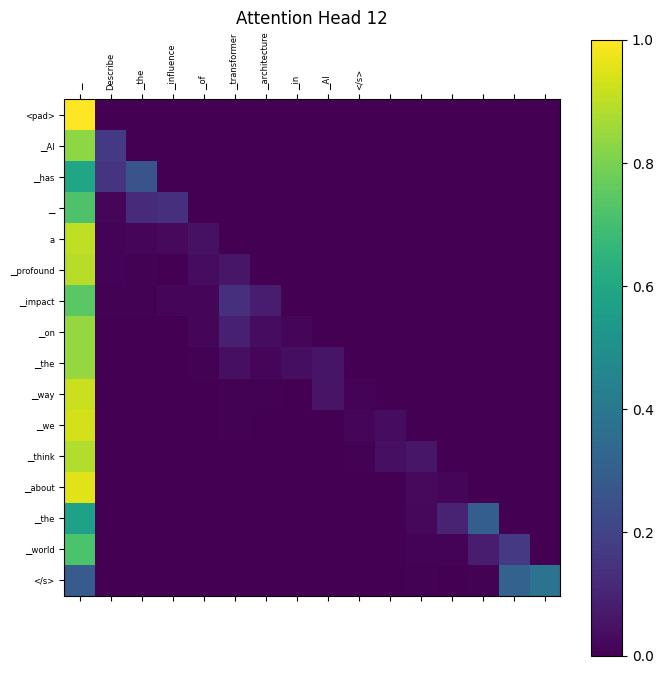

In [10]:
visualize_attention_per_head(new_prompt, response)